**In this notebook:** 
    
    - we plot the expanded contact matrix
    - we plot the ration of the dominant eigenvalue with respect to homogeneous mixing
    - we plot the global assortativity index in the SEP and EDU dimension

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
from matplotlib import cm
import math
import random

import geopandas as gp 
from shapely.geometry import Point, LineString

import datetime as dt

import time

import scipy.stats as st

import seaborn as sns

from matplotlib.colors import LinearSegmentedColormap

from numpy import linalg as LA

In [57]:
plt.rcParams['savefig.transparent']=False
plt.rcParams['savefig.facecolor']='white'

# read population data

In [58]:
# # read population data

data_pop_grouped = pd.read_csv("./../data/pop_size_by_age_SEP_edu.csv")

dict_pop_full = dict(zip(data_pop_grouped[['age_group',
                           'sep_level', 'edu_level']].apply(lambda x:
                                               x[0]+", "+x[1]+", "+x[2], axis=1).values,
                   data_pop_grouped['population']))
                   
pop_age = data_pop_grouped.groupby('age_group')['population'].sum()
pop_age = dict(zip(pop_age.index, pop_age.values))

distrib_pop = data_pop_grouped.groupby('age_group')['population'].sum()/data_pop_grouped['population'].sum()
distrib_pop = dict(zip(distrib_pop.index, distrib_pop.values))

# intermediate matrix

In [59]:
intermediate_matrix_rec = pd.read_csv("./../output/matrices/intermediate_matrix_rec.csv", index_col = 0)
intermediate_matrix_rec = intermediate_matrix_rec.fillna(0)

# colormap

In [60]:
def truncate_colormap(cmap, minval=0., maxval=0.8, n=100):
    """Truncate a colormap to a given range."""
    new_cmap = LinearSegmentedColormap.from_list(
        f"truncated({cmap.name},{minval},{maxval})",
        cmap(np.linspace(minval, maxval, n))
    )
    return new_cmap

cmap = plt.cm.Blues
cmap= truncate_colormap(cmap)

# function to generate expanded contact matrix

In [61]:
def diag_block_children(age, q1_sep):

    #age = '0-14'

    tag_11 = ', low SEP, low edu'
    tag_12 = ', low SEP, high edu'
    tag_21 = ', high SEP, low edu'
    tag_22 = ', high SEP, high edu'

    # 16 unknowns
    # 4 conditions on the sum per row
    # 6 conditions on the reciprocity
    # 4 conditions on the assortativity on the diagonal
    # 1 condition on the assortativity in the edu dimension
    # 1 condition on the assortativity in the sep dimension

    a = np.array([[1., 1., 1., 1.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## sum
                  #[0., 0., 0., 0.,  1., 1., 1., 1.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## sum
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  1., 1., 1., 1.,  0., 0., 0., 0.], ## sum
                  #[0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  1., 1., 1., 1.], ## sum
                  [0., 0., 1., 0.,  
                   0., 0., 0., 0.,  
                   -1., 0., 0., 0.,  
                   0., 0., 0., 0.], ## reciprocity
                  #[1., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## assortativity 1st row
                  ###[0., 0., 0., 0.,  0., 1., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## assortativity 2nd row
                  #[0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 1., 0.,  0., 0., 0., 0.], ## assortativity 3rd row
                  ###[0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 1.], ## assortativity 4th row
                  [1., 1., 0., 0.,  
                   1., 1., 0., 0.,  
                   0., 0., 0., 0.,  
                   0., 0., 0., 0.], ## assortativity sep dimension
                   #### null values
                  [0., 1., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.],
                  [0., 0., 0., 1.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.],
                  [0., 0., 0., 0.,  1., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.],
                  [0., 0., 0., 0.,  0., 1., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.],
                  [0., 0., 0., 0.,  0., 0., 1., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.],
                  [0., 0., 0., 0.,  0., 0., 0., 1.,  0., 0., 0., 0.,  0., 0., 0., 0.],
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 1., 0., 0.,  0., 0., 0., 0.],
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 1.,  0., 0., 0., 0.],
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  1., 0., 0., 0.],
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 1., 0., 0.],
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 1., 0.],
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 1.],
                 ])## assortativity
    b = np.array([intermediate_matrix_rec.loc[age+tag_11][age]*dict_pop_full[age+tag_11], 
                  #intermediate_matrix_rec.iloc[0:4][age].iloc[1],
                  intermediate_matrix_rec.loc[age+tag_21][age]*dict_pop_full[age+tag_21],
                  #intermediate_matrix_rec.iloc[0:4][age].iloc[3],
                  0., #0., 0., 0., 0., 0., 
                  #q111*intermediate_matrix_rec.iloc[0:4][age].iloc[0],
                  #q112*intermediate_matrix_rec.iloc[0:4][age].iloc[1],
                  #q121*intermediate_matrix_rec.iloc[0:4][age].iloc[2],
                  #q122*intermediate_matrix_rec.iloc[0:4][age].iloc[3],
                  q1_sep*(dict_pop_full[age+tag_11]*intermediate_matrix_rec.loc[age+tag_11][age]+dict_pop_full[age+tag_12]*intermediate_matrix_rec.loc[age+tag_12][age]),
                  #q1_edu*(dict_pop_full[age+tag_11]*intermediate_matrix_rec.iloc[0:4][age].iloc[0]+dict_pop_full[age+tag_21]*intermediate_matrix_rec.iloc[0:4][age].iloc[2])
                  ### null values
                  0., 0., 
                  0., 0., 0., 0., 
                  0., 0.,
                  0., 0., 0., 0.])

    x = np.linalg.solve(a, b)
    
    return x

In [62]:
def diag_block_age(age, q11, q12, q21, q22, q_sep, q_edu):

    #age = '15-24'

    tag_11 = ', low SEP, low edu'
    tag_12 = ', low SEP, high edu'
    tag_21 = ', high SEP, low edu'
    tag_22 = ', high SEP, high edu'

    # 16 unknowns
    # 4 conditions on the sum per row
    # 6 conditions on the reciprocity
    # 4 conditions on the assortativity on the diagonal
    # 1 condition on the assortativity in the edu dimension
    # 1 condition on the assortativity in the sep dimension

    a = np.array([[1., 1., 1., 1.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## sum
                  [0., 0., 0., 0.,  1., 1., 1., 1.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## sum
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  1., 1., 1., 1.,  0., 0., 0., 0.], ## sum
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  1., 1., 1., 1.], ## sum
                  [0., 1., 0., 0.,
                   -1., 0., 0., 0.,
                   0., 0., 0., 0.,
                   0., 0., 0., 0.], ## reciprocity
                  [0., 0., 1., 0.,
                   0., 0., 0., 0.,
                   -1., 0., 0., 0.,
                   0., 0., 0., 0.], ## reciprocity
                  [0., 0., 0., 1.,
                   0., 0., 0., 0.,
                   0., 0., 0., 0.,
                   -1., 0., 0., 0.], ## reciprocity
                  [0., 0., 0., 0.,
                   0., 0., 1., 0.,
                   0., -1., 0., 0.,
                   0., 0., 0., 0.], ## reciprocity
                  [0., 0., 0., 0.,
                   0., 0., 0., 1.,
                   0., 0., 0., 0.,
                   0., -1., 0., 0.], ## reciprocity
                  [0., 0., 0., 0.,
                   0., 0., 0., 0.,
                   0., 0., 0., 1.,
                   0., 0., -1., 0.], ## reciprocity
                  [1., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## assortativity 1st row
                  [0., 0., 0., 0.,  0., 1., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## assortativity 2nd row
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 1., 0.,  0., 0., 0., 0.], ## assortativity 3rd row
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 1.], ## assortativity 4th row
                  [1., 1., 0., 0.,
                   1., 1., 0., 0.,
                   0., 0., 0., 0.,
                   0., 0., 0., 0.], ## assortativity sep dimension
                  [1., 0., 1., 0.,
                   0., 0., 0., 0.,
                   1., 0., 1., 0.,
                   0., 0., 0., 0.], ## assortativity edu dimension


                 ])## assortativity
    b = np.array([intermediate_matrix_rec.loc[age+tag_11][age]*dict_pop_full[age+tag_11],
                  intermediate_matrix_rec.loc[age+tag_12][age]*dict_pop_full[age+tag_12],
                  intermediate_matrix_rec.loc[age+tag_21][age]*dict_pop_full[age+tag_21],
                  intermediate_matrix_rec.loc[age+tag_22][age]*dict_pop_full[age+tag_22],
                  0., 0., 0., 0., 0., 0.,
                  q11*intermediate_matrix_rec.loc[age+tag_11][age]*dict_pop_full[age+tag_11],
                  q12*intermediate_matrix_rec.loc[age+tag_12][age]*dict_pop_full[age+tag_12],
                  q21*intermediate_matrix_rec.loc[age+tag_21][age]*dict_pop_full[age+tag_21],
                  q22*intermediate_matrix_rec.loc[age+tag_22][age]*dict_pop_full[age+tag_22],
                  q_sep*(dict_pop_full[age+tag_11]*intermediate_matrix_rec.loc[age+tag_11][age]+dict_pop_full[age+tag_12]*intermediate_matrix_rec.loc[age+tag_12][age]),
                  q_edu*(dict_pop_full[age+tag_11]*intermediate_matrix_rec.loc[age+tag_11][age]+dict_pop_full[age+tag_21]*intermediate_matrix_rec.loc[age+tag_21][age])])

    x = np.linalg.solve(a, b)
    
    return x

In [63]:
def offdiag_block_children(age_i, age_j, q11, q21, q12_sep):

    #age_i = '0-14'
    #age_j = '15-24'

    tag_11 = ', low SEP, low edu'
    tag_12 = ', low SEP, high edu'
    tag_21 = ', high SEP, low edu'
    tag_22 = ', high SEP, high edu'

    a = np.array([[1., 1., 1., 1.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## sum
                  #[0., 0., 0., 0.,  1., 1., 1., 1.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                  # 0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## sum
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  1., 1., 1., 1.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## sum
                  #[0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  1., 1., 1., 1.,
                  # 0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## sum
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                   1., 1., 1., 1.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## sum
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  1., 1., 1., 1.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## sum
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  1., 1., 1., 1.,  0., 0., 0., 0.], ## sum
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  1., 1., 1., 1.], ## sum

                  [1., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## assortatitivy subdiagonal
                  #[0., 0., 0., 0.,  0., 1., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                  # 0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## assortatitivy subdiagonal
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 1., 0.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## assortatitivy subdiagonal
                  #[0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 1.,
                  # 0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## assortatitivy subdiagonal

                  #[0., 1., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                  # 0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## subassortatitivy
                  #[0., 0., 0., 0.,  0., 0., 1., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                  # 0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## subassortatitivy
                  #[0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 1.,  0., 0., 0., 0.,
                  # 0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## subassortatitivy


                [1., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                   -1., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## reciprocity
                  [0., 1., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  -1., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## reciprocity
                  [0., 0., 1., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  -1., 0., 0., 0.,  0., 0., 0., 0.], ## reciprocity
                  [0., 0., 0., 1.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  -1., 0., 0., 0.], ## reciprocity

                #[0., 0., 0., 0.,  dict_pop_full[age_i+tag_12], 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                #   0., -dict_pop_full[age_j+tag_11], 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## reciprocity
                #  [0., 0., 0., 0.,  0., dict_pop_full[age_i+tag_12], 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                #   0., 0., 0., 0.,  0., -dict_pop_full[age_j+tag_12], 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## reciprocity
                #  [0., 0., 0., 0.,  0., 0., dict_pop_full[age_i+tag_12], 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                #   0., 0., 0., 0.,  0., 0., 0., 0.,  0., -dict_pop_full[age_j+tag_21], 0., 0.,  0., 0., 0., 0.], ## reciprocity
                #  [0., 0., 0., 0.,  0., 0., 0., dict_pop_full[age_i+tag_12],  0., 0., 0., 0.,  0., 0., 0., 0.,
                #   0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., -dict_pop_full[age_j+tag_22], 0., 0.], ## reciprocity

                [0., 0., 0., 0.,  0., 0., 0., 0., 1., 0., 0., 0.,  0., 0., 0., 0.,
                   0., 0., -1., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## reciprocity
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 1., 0., 0.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  0., 0., -1.,  0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## reciprocity
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 1., 0.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., -1., 0.,  0., 0., 0., 0.], ## reciprocity
                #  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., dict_pop_full[age_i+tag_21],  0., 0., 0., 0.,
                #   0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., -dict_pop_full[age_j+tag_22], 0.], ## reciprocity

                #  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  dict_pop_full[age_i+tag_22], 0., 0., 0.,
                #   0., 0., 0., -dict_pop_full[age_j+tag_11],  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## reciprocity
                #  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., dict_pop_full[age_i+tag_22], 0., 0.,
                #   0., 0., 0., 0.,  0., 0., 0., -dict_pop_full[age_j+tag_12],  0., 0., 0., 0.,  0., 0., 0., 0.], ## reciprocity
                #  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., dict_pop_full[age_i+tag_22], 0.,
                #   0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., -dict_pop_full[age_j+tag_21],  0., 0., 0., 0.], ## reciprocity
                  #[0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., dict_pop_full[age_i+tag_22],
                  # 0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., -dict_pop_full[age_j+tag_22]], ## reciprocity

                 [1., 1., 0., 0.,
                   1., 1., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## assortativity sep dimension
                 # [dict_pop_full[age_i+tag_11], 0., dict_pop_full[age_i+tag_11], 0.,
                 #  0., 0., 0., 0.,
                 #  dict_pop_full[age_i+tag_21], 0., dict_pop_full[age_i+tag_21], 0.,
                 #  0., 0., 0., 0.,
                 #  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## assortativity edu dimension
                 ### null values
                  [0., 0., 0., 0.,  1., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.],
                  [0., 0., 0., 0.,  0., 1., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.],
                  [0., 0., 0., 0.,  0., 0., 1., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.],
                  [0., 0., 0., 0.,  0., 0., 0., 1.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.],
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  1., 0., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.],
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 1., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.],
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 1., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.],
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 1.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.],
                  
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                   0., 1., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.],
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                   0., 0., 0., 1.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.],
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  0., 1., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.],
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 1.,  0., 0., 0., 0.,  0., 0., 0., 0.],
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  0., 1., 0., 0.,  0., 0., 0., 0.],
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 1.,  0., 0., 0., 0.],
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 1., 0., 0.],
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 1.],
               ],
                )

    b = np.array([intermediate_matrix_rec.loc[age_i+tag_11][age_j]*dict_pop_full[age_i+tag_11],
                  #intermediate_matrix_rec.iloc[0:4][age_j].iloc[1],
                  intermediate_matrix_rec.loc[age_i+tag_21][age_j]*dict_pop_full[age_i+tag_21],
                  #intermediate_matrix_rec.iloc[0:4][age_j].iloc[3],
                  intermediate_matrix_rec.loc[age_j+tag_11][age_i]*dict_pop_full[age_j+tag_11],
                  intermediate_matrix_rec.loc[age_j+tag_12][age_i]*dict_pop_full[age_j+tag_12],
                  intermediate_matrix_rec.loc[age_j+tag_21][age_i]*dict_pop_full[age_j+tag_21],
                  intermediate_matrix_rec.loc[age_j+tag_22][age_i]*dict_pop_full[age_j+tag_22],
                  q11*intermediate_matrix_rec.loc[age_i+tag_11][age_j]*dict_pop_full[age_i+tag_11],
                  #q12*intermediate_matrix_rec.iloc[0:4][age_j].iloc[1],
                  q21*intermediate_matrix_rec.loc[age_i+tag_21][age_j]*dict_pop_full[age_i+tag_21],
                  #q22*intermediate_matrix_rec.iloc[0:4][age_j].iloc[3],
                  #r1*(1.-q11)*intermediate_matrix_rec.iloc[0:4][age_j].iloc[0],
                  #r2*(1.-q12)*intermediate_matrix_rec.iloc[0:4][age_j].iloc[1],
                  #r3*(1.-q21)*intermediate_matrix_rec.iloc[0:4][age_j].iloc[2],
                  0., 0., 0., 0.,
                  #0., 0., 0., 0.,
                  0., 0., 0., #0.,
                  #0., 0., 0., #0.,
                  q12_sep*(dict_pop_full[age_i+tag_11]*intermediate_matrix_rec.loc[age_i+tag_11][age_j]+dict_pop_full[age_i+tag_12]*intermediate_matrix_rec.loc[age_i+tag_12][age_j]),
                  #q12_edu*(dict_pop_full[age_i+tag_11]*intermediate_matrix_rec.iloc[0:4][age_j].iloc[0]+dict_pop_full[age_i+tag_21]*intermediate_matrix_rec.iloc[0:4][age_j].iloc[2]),
                  ### null values (16)
                  0., 0., 0., 0.,
                  0., 0., 0., 0.,
                  0., 0.,
                  0., 0.,
                  0., 0.,
                  0., 0.,
                 ])

    x = np.linalg.solve(a, b)
    
    return x

In [64]:
def offdiag_block_age(age_i, age_j, q11, q12, q21, q22, r1, r2, r3, q_sep, q_edu):

    #age_i = '15-24'
    #age_j = '25-64'

    tag_11 = ', low SEP, low edu'
    tag_12 = ', low SEP, high edu'
    tag_21 = ', high SEP, low edu'
    tag_22 = ', high SEP, high edu'

    a = np.array([[1., 1., 1., 1.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## sum
                  [0., 0., 0., 0.,  1., 1., 1., 1.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## sum
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  1., 1., 1., 1.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## sum
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  1., 1., 1., 1.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## sum
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                   1., 1., 1., 1.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## sum
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  1., 1., 1., 1.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## sum
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  1., 1., 1., 1.,  0., 0., 0., 0.], ## sum
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  1., 1., 1., 1.], ## sum

                  [1., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## assortatitivy subdiagonal
                  [0., 0., 0., 0.,  0., 1., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## assortatitivy subdiagonal
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 1., 0.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## assortatitivy subdiagonal
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 1.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## assortatitivy subdiagonal

                 [0., 1., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## subassortatitivy
                  [0., 0., 0., 0.,  0., 0., 1., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## subassortatitivy
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 1.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## subassortatitivy


                [1., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                   -1., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## reciprocity
                  [0., 1., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  -1., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## reciprocity
                  [0., 0., 1., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  -1., 0., 0., 0.,  0., 0., 0., 0.], ## reciprocity
                  [0., 0., 0., 1.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  -1., 0., 0., 0.], ## reciprocity

                [0., 0., 0., 0.,  1., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                   0., -1., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## reciprocity
                  [0., 0., 0., 0.,  0., 1., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  0., -1., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## reciprocity
                  [0., 0., 0., 0.,  0., 0., 1., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  0., -1., 0., 0.,  0., 0., 0., 0.], ## reciprocity
                  [0., 0., 0., 0.,  0., 0., 0., 1.,  0., 0., 0., 0.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., -1., 0., 0.], ## reciprocity

                [0., 0., 0., 0.,  0., 0., 0., 0.,  1., 0., 0., 0.,  0., 0., 0., 0.,
                   0., 0., -1., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## reciprocity
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 1., 0., 0.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  0., 0., -1., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## reciprocity
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 1., 0.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., -1., 0.,  0., 0., 0., 0.], ## reciprocity
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 1.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., -1., 0.], ## reciprocity

                  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  1., 0., 0., 0.,
                   0., 0., 0., -1.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## reciprocity
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 1., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., -1.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## reciprocity
                  [0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 1., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., -1.,  0., 0., 0., 0.], ## reciprocity
                  #[0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., dict_pop_full[age_i+tag_22],
                  # 0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., -dict_pop_full[age_j+tag_22]], ## reciprocity

                 [1., 1., 0., 0.,
                   1., 1., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## assortativity sep dimension
                  [1., 0., 1., 0.,
                   0., 0., 0., 0.,
                   1., 0., 1., 0.,
                   0., 0., 0., 0.,
                   0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.,  0., 0., 0., 0.], ## assortativity edu dimension
                  ])

    b = np.array([intermediate_matrix_rec.loc[age_i+tag_11][age_j]*dict_pop_full[age_i+tag_11],
                  intermediate_matrix_rec.loc[age_i+tag_12][age_j]*dict_pop_full[age_i+tag_12],
                  intermediate_matrix_rec.loc[age_i+tag_21][age_j]*dict_pop_full[age_i+tag_21],
                  intermediate_matrix_rec.loc[age_i+tag_22][age_j]*dict_pop_full[age_i+tag_22],
                  intermediate_matrix_rec.loc[age_j+tag_11][age_i]*dict_pop_full[age_j+tag_11],
                  intermediate_matrix_rec.loc[age_j+tag_12][age_i]*dict_pop_full[age_j+tag_12],
                  intermediate_matrix_rec.loc[age_j+tag_21][age_i]*dict_pop_full[age_j+tag_21],
                  intermediate_matrix_rec.loc[age_j+tag_22][age_i]*dict_pop_full[age_j+tag_22],
                  q11*intermediate_matrix_rec.loc[age_i+tag_11][age_j]*dict_pop_full[age_i+tag_11],
                  q12*intermediate_matrix_rec.loc[age_i+tag_12][age_j]*dict_pop_full[age_i+tag_12],
                  q21*intermediate_matrix_rec.loc[age_i+tag_21][age_j]*dict_pop_full[age_i+tag_21],
                  q22*intermediate_matrix_rec.loc[age_i+tag_22][age_j]*dict_pop_full[age_i+tag_22],
                  r1*(1.-q11)*intermediate_matrix_rec.loc[age_i+tag_11][age_j]*dict_pop_full[age_i+tag_11],
                  r2*(1.-q12)*intermediate_matrix_rec.loc[age_i+tag_12][age_j]*dict_pop_full[age_i+tag_12],
                  r3*(1.-q21)*intermediate_matrix_rec.loc[age_i+tag_21][age_j]*dict_pop_full[age_i+tag_21],
                  0., 0., 0., 0.,
                  0., 0., 0., 0.,
                  0., 0., 0., 0.,
                  0., 0., 0., #0.,
                  q_sep*(dict_pop_full[age_i+tag_11]*intermediate_matrix_rec.loc[age_i+tag_11][age_j]+dict_pop_full[age_i+tag_12]*intermediate_matrix_rec.loc[age_i+tag_12][age_j]),
                  q_edu*(dict_pop_full[age_i+tag_11]*intermediate_matrix_rec.loc[age_i+tag_11][age_j]+dict_pop_full[age_i+tag_21]*intermediate_matrix_rec.loc[age_i+tag_21][age_j]),
                 ])

    x = np.linalg.solve(a, b)
    
    return x

# solve system with a given combination of parameters

In [65]:
matrix_features = pd.read_csv("./../output/matrices/10000_matrices_characteristics.csv")
params = pd.read_csv("./../output/matrices/10000_sampled_combinations.csv")

In [66]:
matrix_features.head()

,ratio_egv_max,list_ass_sep_trace,list_ass_edu_trace,ratio_egv_max_quant,list_ass_sep_trace_quant,list_ass_edu_trace_quant,list_eigv_ratio_keep_sep,list_eigv_ratio_keep_edu
0,1.006346,1.209947,1.312709,0-20,40-60,80-100,1.002102,1.002776
1,1.006850,1.232992,1.233100,40-60,60-80,60-80,1.002715,1.002874
2,1.006992,1.103313,1.205484,40-60,20-40,60-80,1.002333,1.002970
3,1.006982,1.111644,1.195376,40-60,20-40,60-80,1.001920,1.002873
4,1.007390,1.310728,1.300757,60-80,80-100,80-100,1.002568,1.003002


In [67]:
params.head()

,block1,block2,block3,block12,block13,block23,block0,block01,block02,block03
0,"[0.441870780340922, 0.3462914691592924, 0.6006...","[0.6935341561806575, 0.0418654822467021, 0.716...","[0.2825564021024302, 0.1041343067622532, 0.767...","[0.30690686617555, 0.267609305080417, 0.297510...","[0.251916184819389, 0.1153453916178977, 0.3981...","[0.0334976644339346, 0.288083220650814, 0.3240...",[0.2246784351181315],"[0.6210624889774469, 0.7317896327978364, 0.724...","[0.4031665517423877, 0.4552146466822631, 0.408...","[0.2148389111611139, 0.0803573130192042, 0.264..."
1,"[0.8543670085756274, 0.0058984746163363, 0.871...","[0.0693621084701211, 0.5622305897271339, 0.650...","[0.3929727356247542, 0.428042378752117, 0.8568...","[0.2869485160389887, 0.0544500981990297, 0.616...","[0.1708842355711997, 0.2659007930121206, 0.470...","[0.5865371773935384, 0.1562158722226703, 0.603...",[0.4523719497197641],"[0.2837738477876314, 0.5364571286438398, 0.316...","[0.5034545010239297, 0.4035008771762823, 0.654...","[0.3699622386311065, 0.1375770912449009, 0.443..."
2,"[0.5603981177892123, 0.1472693610036157, 0.733...","[0.1037930795580666, 0.0639734732612258, 0.286...","[0.4318627760463763, 0.0037756243841278, 0.534...","[0.4875331825009599, 0.2153102014290412, 0.499...","[0.2021967720934547, 0.0238365883658476, 0.527...","[0.0973912759261441, 0.0812379674082151, 0.462...",[0.834014480512304],"[0.4652609475639261, 0.6462657340735124, 0.549...","[0.0002996088476703, 0.2176367019489065, 0.261...","[0.3194573406810401, 0.3440725826517126, 0.412..."
3,"[0.2108813919588652, 0.0384990948447813, 0.490...","[0.0867189351915543, 0.6214236377504522, 0.189...","[0.5288772465982243, 0.6355151592614743, 0.393...","[0.3948577584514288, 0.6985057845077757, 0.457...","[0.1033742252396894, 0.0894025266136409, 0.726...","[0.5808453166114715, 0.1071450777342477, 0.889...",[0.098579208818828],"[0.6812055019718825, 0.759308401995378, 0.7996...","[0.1233010577034996, 0.2174806361632265, 0.360...","[0.1953377205730084, 0.3531553860970605, 0.288..."
4,"[0.5592760991978437, 0.2251108883977681, 0.744...","[0.324593602032119, 0.2596648052231923, 0.7377...","[0.6267827532652541, 0.6524717651560187, 0.613...","[0.3161348382656689, 0.1111623825681278, 0.514...","[0.2019810300607091, 0.5541245962940057, 0.752...","[0.3594014995993573, 0.0482911043698991, 0.648...",[0.9921637660718224],"[0.7305780964059831, 0.7949691605733983, 0.871...","[0.4169207524095046, 0.2371894669346036, 0.478...","[0.0697121663314026, 0.2151971620433952, 0.193..."


In [68]:
for h,q in enumerate(['q11', 'q12', 'q21', 'q22', 'q_sep', 'q_edu']):
    params['block1_{}'.format(q)] = params['block1'].apply(lambda x: 
                                    np.array(x[1:-1].split(", "), dtype=np.float32)[h])

    params['block2_{}'.format(q)] = params['block2'].apply(lambda x: 
                                    np.array(x[1:-1].split(", "), dtype=np.float32)[h])

    params['block3_{}'.format(q)] = params['block3'].apply(lambda x: 
                                    np.array(x[1:-1].split(", "), dtype=np.float32)[h])
    
for h,q in enumerate(['q11', 'q12', 'q21', 'q22', 'r1', 'r2', 'r3', 'q_sep', 'q_edu']):
    params['block12_{}'.format(q)] = params['block12'].apply(lambda x: 
                                    np.array(x[1:-1].split(", "), dtype=np.float32)[h])
    
    params['block13_{}'.format(q)] = params['block13'].apply(lambda x: 
                                    np.array(x[1:-1].split(", "), dtype=np.float32)[h])
    
    params['block23_{}'.format(q)] = params['block23'].apply(lambda x: 
                                    np.array(x[1:-1].split(", "), dtype=np.float32)[h])
    
for h,q in enumerate(['q_sep']):
    params['block0_{}'.format(q)] = params['block0'].apply(lambda x: 
                                    np.array(x[1:-1].split(", "), dtype=np.float32)[h]) 
    
    
for h,q in enumerate(['q11', 'q21', 'q_sep']):
    params['block01_{}'.format(q)] = params['block01'].apply(lambda x: 
                                    np.array(x[1:-1].split(", "), dtype=np.float32)[h]) 
    
    params['block02_{}'.format(q)] = params['block02'].apply(lambda x: 
                                    np.array(x[1:-1].split(", "), dtype=np.float32)[h]) 

    params['block03_{}'.format(q)] = params['block03'].apply(lambda x: 
                                    np.array(x[1:-1].split(", "), dtype=np.float32)[h]) 

In [69]:
def generate_matrix(combination):
    
    c = combination

    ## diagonal block 1
    q11, q12, q21, q22, q_sep, q_edu = params.iloc[c][[col for col in params.columns if 'block1_' in col]].values
    x1 = diag_block_age('15-24', q11, q12, q21, q22, q_sep, q_edu)

    ## diagonal block 2
    q11, q12, q21, q22, q_sep, q_edu = params.iloc[c][[col for col in params.columns if 'block2_' in col]].values
    x2 = diag_block_age('25-64', q11, q12, q21, q22, q_sep, q_edu)

    ## diagonal block 3
    q11, q12, q21, q22, q_sep, q_edu = params.iloc[c][[col for col in params.columns if 'block3_' in col]].values
    x3 = diag_block_age('65+', q11, q12, q21, q22, q_sep, q_edu)

    ## block 12
    q11, q12, q21, q22, r1, r2, r3, q_sep, q_edu = params.iloc[c][[col for col in params.columns if 'block12_' in col]].values
    x12 = offdiag_block_age('15-24', '25-64', q11, q12, q21, q22, r1, r2, r3, q_sep, q_edu)

    ## block 13
    q11, q12, q21, q22, r1, r2, r3, q_sep, q_edu = params.iloc[c][[col for col in params.columns if 'block13_' in col]].values
    x13 = offdiag_block_age('15-24', '65+', q11, q12, q21, q22, r1, r2, r3, q_sep, q_edu)

    ## block 23
    q11, q12, q21, q22, r1, r2, r3, q_sep, q_edu = params.iloc[c][[col for col in params.columns if 'block23_' in col]].values
    x23 = offdiag_block_age('25-64', '65+', q11, q12, q21, q22, r1, r2, r3, q_sep, q_edu)
    
    ## diagonal block 0
    par = params.iloc[c][[col for col in params.columns if 'block0_' in col]].values
    q_sep = par[0]
    x0 = diag_block_children('0-14', q_sep)        

    ## block 01
    par = params.iloc[c][[col for col in params.columns if 'block01_' in col]].values
    q11, q21, q_sep = par
    x01 = offdiag_block_children('0-14', '15-24', q11, q21, q_sep)

    ## block 02
    par = params.iloc[c][[col for col in params.columns if 'block02_' in col]].values
    q11, q21, q_sep = par
    x02 = offdiag_block_children('0-14', '25-64',q11, q21, q_sep)

    ## block 0
    par = params.iloc[c][[col for col in params.columns if 'block03_' in col]].values
    q11, q21, q_sep = par
    x03 = offdiag_block_children('0-14', '65+',q11, q21, q_sep)

    matrix_expanded_positive = np.zeros((16,16))

    matrix_expanded_positive[0:4,0:4] = x0.reshape(4,4)
    matrix_expanded_positive[4:8,4:8] = x1.reshape(4,4)
    matrix_expanded_positive[8:12,8:12] = x2.reshape(4,4)
    matrix_expanded_positive[12:16,12:16] = x3.reshape(4,4)

    matrix_expanded_positive[0:4,4:8] = x01.reshape(8,4)[:4]
    matrix_expanded_positive[4:8,0:4] = x01.reshape(8,4)[4:]

    matrix_expanded_positive[0:4,8:12] = x02.reshape(8,4)[:4]
    matrix_expanded_positive[8:12,0:4] = x02.reshape(8,4)[4:]

    matrix_expanded_positive[0:4,12:16] = x03.reshape(8,4)[:4]
    matrix_expanded_positive[12:16,0:4] = x03.reshape(8,4)[4:]

    matrix_expanded_positive[4:8,8:12] = x12.reshape(8,4)[:4]
    matrix_expanded_positive[8:12,4:8] = x12.reshape(8,4)[4:]

    matrix_expanded_positive[4:8,12:16] = x13.reshape(8,4)[:4]
    matrix_expanded_positive[12:16,4:8] = x13.reshape(8,4)[4:]

    matrix_expanded_positive[8:12,12:16] = x23.reshape(8,4)[:4]
    matrix_expanded_positive[12:16,8:12] = x23.reshape(8,4)[4:]

    matrix_expanded_positive = pd.DataFrame(matrix_expanded_positive)
    matrix_expanded_positive.index = intermediate_matrix_rec.index
    matrix_expanded_positive.columns = intermediate_matrix_rec.index

    matrix_expanded = matrix_expanded_positive.copy()
    
    df = matrix_expanded.values  # Convert DataFrame to NumPy array
    
    if np.allclose(df, df.T, atol=1e-8)==False: ## check symmetry of the matrix
        sys.exit()
        
    else:    
        ## this is the symmetric matrix with the total number of contacts between two groups 
        ## T_ij = M_ij*N_i = M_ji*N_j = T_ji 

        ## to compute the contact matrix of the number of contacts per participant, dived each row by the size of the 
        ## M_ij = T_ij/N_i
        
        for g in matrix_expanded.columns:
            if dict_pop_full[g]!= 0.:
                matrix_expanded.loc[g] = matrix_expanded.loc[g]/dict_pop_full[g]
            else:
                matrix_expanded.loc[g] = np.nan
        
        for g in matrix_expanded.columns:
            if dict_pop_full[g]== 0.:
                matrix_expanded[g] = np.nan
    
        return matrix_expanded

## choose matrix to plot

In [70]:
h = 3
combination = matrix_features[(matrix_features['ratio_egv_max_quant'].isin(['40-60'])) & 
                (matrix_features['list_ass_sep_trace_quant'].isin(['40-60'])) &
                (matrix_features['list_ass_edu_trace_quant'].isin(['40-60']))].index[h]
combination

841

In [71]:
#combination = 23
#combination = 95
#combination = 97
#combination = 2024
#combination = 2023
combination = 841

matrix_features.iloc[combination]

ratio_egv_max               1.006848
list_ass_sep_trace          1.192476
list_ass_edu_trace          1.098469
ratio_egv_max_quant            40-60
list_ass_sep_trace_quant       40-60
list_ass_edu_trace_quant       40-60
list_eigv_ratio_keep_sep    1.001733
list_eigv_ratio_keep_edu    1.002947
Name: 841, dtype: object

In [72]:
print(params.iloc[combination].loc[['block1_q11', 'block2_q11', 'block3_q11']])
print(params.iloc[combination].loc[['block1_q12', 'block2_q12', 'block3_q12']])
print(params.iloc[combination].loc[['block1_q21', 'block2_q21', 'block3_q21']])
print(params.iloc[combination].loc[['block1_q22', 'block2_q22', 'block3_q22']])
print(params.iloc[combination].loc[['block1_q_sep', 'block2_q_sep', 'block3_q_sep']])
print(params.iloc[combination].loc[['block1_q_edu', 'block2_q_edu', 'block3_q_edu']])

block1_q11    0.085165
block2_q11    0.340268
block3_q11     0.78705
Name: 841, dtype: object
block1_q12    0.079128
block2_q12    0.190943
block3_q12    0.504968
Name: 841, dtype: object
block1_q21    0.453387
block2_q21    0.441679
block3_q21    0.804919
Name: 841, dtype: object
block1_q22    0.059015
block2_q22     0.11157
block3_q22    0.616434
Name: 841, dtype: object
block1_q_sep    0.172664
block2_q_sep    0.371377
block3_q_sep    0.741797
Name: 841, dtype: object
block1_q_edu    0.940212
block2_q_edu     0.56229
block3_q_edu    0.895428
Name: 841, dtype: object


In [73]:
print(params.iloc[combination].loc[['block12_q11', 'block13_q11', 'block23_q11']])
print(params.iloc[combination].loc[['block12_q12', 'block13_q12', 'block23_q12']])
print(params.iloc[combination].loc[['block12_q21', 'block13_q21', 'block23_q21']])
print(params.iloc[combination].loc[['block12_q22', 'block13_q22', 'block23_q22']])
print(params.iloc[combination].loc[['block12_q_sep', 'block13_q_sep', 'block23_q_sep']])
print(params.iloc[combination].loc[['block12_q_edu', 'block13_q_edu', 'block23_q_edu']])
print(params.iloc[combination].loc[['block12_r1', 'block13_r1', 'block23_r1']])
print(params.iloc[combination].loc[['block12_r2', 'block13_r2', 'block23_r2']])
print(params.iloc[combination].loc[['block12_r3', 'block13_r3', 'block23_r3']])

block12_q11    0.020816
block13_q11    0.115454
block23_q11    0.291459
Name: 841, dtype: object
block12_q12    0.229031
block13_q12    0.116724
block23_q12    0.063458
Name: 841, dtype: object
block12_q21    0.261397
block13_q21    0.686173
block23_q21    0.631284
Name: 841, dtype: object
block12_q22    0.120487
block13_q22    0.162243
block23_q22    0.142816
Name: 841, dtype: object
block12_q_sep    0.145119
block13_q_sep    0.278412
block23_q_sep    0.458476
Name: 841, dtype: object
block12_q_edu    0.558079
block13_q_edu    0.645529
block23_q_edu    0.643825
Name: 841, dtype: object
block12_r1    0.106707
block13_r1    0.219537
block23_r1    0.221126
Name: 841, dtype: object
block12_r2    0.413632
block13_r2    0.328571
block23_r2    0.036267
Name: 841, dtype: object
block12_r3    0.505175
block13_r3     0.51579
block23_r3    0.627079
Name: 841, dtype: object


In [74]:
print(params.iloc[combination].loc[['block0_q_sep']])
print(params.iloc[combination].loc[['block01_q11', 'block02_q11', 'block03_q11']])
print(params.iloc[combination].loc[['block01_q21', 'block02_q21', 'block03_q21']])
print(params.iloc[combination].loc[['block01_q_sep', 'block02_q_sep', 'block03_q_sep']])

block0_q_sep    0.9695
Name: 841, dtype: object
block01_q11     0.64806
block02_q11    0.196301
block03_q11    0.507411
Name: 841, dtype: object
block01_q21     0.71168
block02_q21    0.346884
block03_q21    0.362632
Name: 841, dtype: object
block01_q_sep    0.667227
block02_q_sep    0.370325
block03_q_sep    0.516446
Name: 841, dtype: object


## plot

In [75]:
matrix_expanded = generate_matrix(combination)

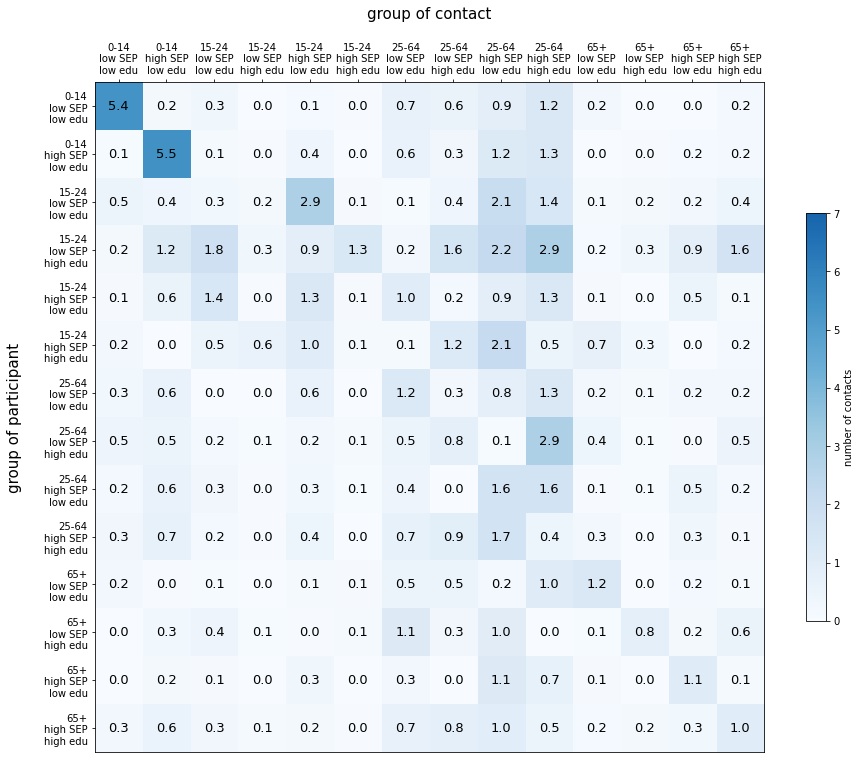

In [76]:
fig, ax_main = plt.subplots(figsize=(15,15))

df_plot = matrix_expanded.copy()

df_plot = df_plot.dropna(how='all', axis = 0)
df_plot = df_plot.dropna(how='all', axis = 1)

# Plot heatmap using Matplotlib
plt.imshow(df_plot, 
           cmap=cmap,
           interpolation='nearest', 
           vmin=math.floor(df_plot.min().min()), vmax=7)#vmax=math.ceil(df_plot.max().max()))

# Add color bar
plt.colorbar(label='number of contacts', shrink=0.5)

# Set ticks
plt.xticks(range(len(df_plot.columns)), [c.replace(", ", "\n") for c in df_plot.columns])#[c.replace(", ", "\n").replace(" ", "\n") for c in df_plot.columns])
plt.tick_params(axis='x', which='both', bottom=False, top=True, labelbottom=False, labeltop=True)
plt.yticks(range(len(df_plot.index)), [c.replace(", ", "\n") for c in df_plot.index])

# Set labels and title
plt.ylabel('group of participant\n', fontsize=15)

plt.title('group of contact\n', fontsize=15)

# Overlay dashed grid for NaN cells
for i in range(df_plot.shape[0]):
    for j in range(df_plot.shape[1]):
        if np.isnan(df_plot.iloc[i, j]):
            # Add a rectangle with a dashed edge
            rect = Rectangle((j - 0.5, i - 0.5), 1, 1, edgecolor='gray', facecolor='lightgray', alpha = 0.2, linestyle='-', hatch='//')
            ax_main.add_patch(rect)

# Add annotations
for i in range(len(df_plot.index)):
    for j in range(len(df_plot.columns)):
        if df_plot.values[i,j]>0:
            plt.text(j, i, np.around(df_plot.values[i, j],1), 
                 ha='center', va='center', color='black', fontsize=13)

plt.savefig("./../output/figures/expanded_contact_matrix_comb{}.png".format(combination), dpi=200, bbox_inches="tight")

plt.show()

## aggregated SEP-stratified matrix

In [77]:
def compute_M_sep(matrix_expanded):
    
    a = []
    for age_i in ['low SEP', 'high SEP']:
        for age_j in ['low SEP', 'high SEP']:
            idx = [h for h in matrix_expanded.index if age_i in h]
            col = [h for h in matrix_expanded.columns if age_j in h]
            sub_matrix = matrix_expanded.loc[idx][col]

            num = sum([sub_matrix.iloc[h].sum()*dict_pop_full[idx[h]] for h in np.arange(len(sub_matrix))])
            den = sum([dict_pop_full[idx[h]] for h in np.arange(len(sub_matrix))])
            a.append(num/den)

    M_sep = pd.DataFrame(np.array(a).reshape(2,2))

    M_sep.index = ['low SEP', 'high SEP']
    M_sep.columns = ['low SEP', 'high SEP']
    
    return M_sep

M_sep = compute_M_sep(matrix_expanded)

M_sep

,low SEP,high SEP
low SEP,3.104540,3.777696
high SEP,1.688621,4.840772


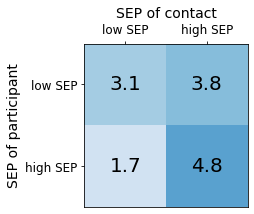

In [78]:
plt.figure(figsize=(3,3))

df_plot = M_sep.copy()

# Plot heatmap using Matplotlib
plt.imshow(df_plot, 
           cmap=cmap,
           interpolation='nearest', 
           vmin = 0, vmax=7)
           #vmin=math.floor(df_plot.min().min()), vmax=math.ceil(df_plot.max().max()))

# Add color bar
#plt.colorbar(shrink = 0.5, label='number of contacts')

# Set ticks
plt.xticks(range(len(df_plot.columns)), [c.replace("_", "\n") for c in df_plot.columns], fontsize=12)
plt.tick_params(axis='x', which='both', bottom=False, top=True, labelbottom=False, labeltop=True)
plt.yticks(range(len(df_plot.index)), [c.replace("_", "\n") for c in df_plot.index], fontsize=12)

# Set labels and title
plt.ylabel('SEP of participant', fontsize=14)

plt.title('SEP of contact', fontsize=14)

# Add annotations
for i in range(len(df_plot.index)):
    for j in range(len(df_plot.columns)):
        plt.text(j, i, np.around(df_plot.values[i, j],1), 
                 ha='center', va='center', color='black', fontsize=20)
        
plt.savefig("./../output/figures/expanded_contact_matrix_comb{}_sep_only.png".format(combination), 
            dpi=200, bbox_inches="tight")

plt.show()

## aggregated SES-stratified matrix

In [79]:
def compute_M_edu(matrix_expanded):
    a = []
    for age_i in ['low edu', 'high edu']:
        for age_j in ['low edu', 'high edu']:
            idx = [h for h in matrix_expanded.index if age_i in h]
            col = [h for h in matrix_expanded.columns if age_j in h]
            sub_matrix = matrix_expanded.loc[idx][col]

            num = sum([sub_matrix.iloc[h].sum()*dict_pop_full[idx[h]] for h in np.arange(len(sub_matrix))])
            den = sum([dict_pop_full[idx[h]] for h in np.arange(len(sub_matrix))])
            a.append(num/den)

    M_edu = pd.DataFrame(np.array(a).reshape(2,2))

    M_edu.index = ['low edu', 'high edu']
    M_edu.columns = ['low edu', 'high edu']
    
    return M_edu

M_edu = compute_M_edu(matrix_expanded)

M_edu

,low edu,high edu
low edu,4.978645,1.822010
high edu,3.981508,2.302299


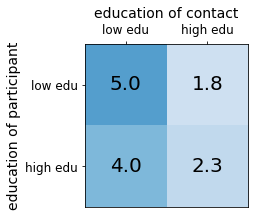

In [80]:
plt.figure(figsize=(3,3))

df_plot = M_edu.copy()

# Plot heatmap using Matplotlib
plt.imshow(df_plot, 
           cmap=cmap,
           interpolation='nearest', 
           vmin=0, vmax=7)
           #vmin=math.floor(df_plot.min().min()), vmax=math.ceil(df_plot.max().max()))

# Add color bar
#plt.colorbar(shrink = 0.5, label='number of contacts')

# Set ticks
plt.xticks(range(len(df_plot.columns)), [c.replace("_", "\n") for c in df_plot.columns], fontsize=12)
plt.tick_params(axis='x', which='both', bottom=False, top=True, labelbottom=False, labeltop=True)
plt.yticks(range(len(df_plot.index)), [c.replace("_", "\n") for c in df_plot.index], fontsize=12)

# Set labels and title
plt.ylabel('education of participant', fontsize=14)

plt.title('education of contact', fontsize=14)

# Add annotations
for i in range(len(df_plot.index)):
    for j in range(len(df_plot.columns)):
        plt.text(j, i, np.around(df_plot.values[i, j],1), 
                 ha='center', va='center', color='black', fontsize=20)

plt.savefig("./../output/figures/expanded_contact_matrix_comb{}_edu_only.png".format(combination), 
            dpi=200, bbox_inches="tight")


plt.show()

# plot assortativity index

In [81]:
res = matrix_features.copy()

res.head()

,ratio_egv_max,list_ass_sep_trace,list_ass_edu_trace,ratio_egv_max_quant,list_ass_sep_trace_quant,list_ass_edu_trace_quant,list_eigv_ratio_keep_sep,list_eigv_ratio_keep_edu
0,1.006346,1.209947,1.312709,0-20,40-60,80-100,1.002102,1.002776
1,1.006850,1.232992,1.233100,40-60,60-80,60-80,1.002715,1.002874
2,1.006992,1.103313,1.205484,40-60,20-40,60-80,1.002333,1.002970
3,1.006982,1.111644,1.195376,40-60,20-40,60-80,1.001920,1.002873
4,1.007390,1.310728,1.300757,60-80,80-100,80-100,1.002568,1.003002


In [82]:
pal = ["#22577a","#38a3a5","#57cc99","#80ed99","#c7f9cc"]
pal.reverse()

def assign_color(x):
    if x == '0-20':
        return pal[0]
    elif x == '20-40':
        return pal[1]
    elif x == '40-60':
        return pal[2]
    elif x == '60-80':
        return pal[3]
    #elif x > res['ratio_egv_max'].quantile(0.95):
        #return 'black'
    else:
        return pal[4]
    
res['color'] = res['ratio_egv_max_quant'].apply(lambda x: assign_color(x))

In [83]:
combination

841

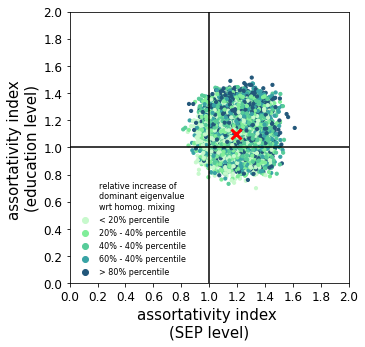

In [84]:
plt.figure(figsize=(5,5))

plt.scatter([],[], color='white', label = "relative increase of \ndominant eigenvalue \nwrt homog. mixing")
plt.scatter([],[], color=pal[0], label = "< 20% percentile")
plt.scatter([],[], color=pal[1], label = "20% - 40% percentile")
plt.scatter([],[], color=pal[2], label = "40% - 40% percentile")
plt.scatter([],[], color=pal[3], label = "60% - 40% percentile")
plt.scatter([],[], color=pal[4], label = "> 80% percentile")
#plt.scatter([],[], color='black', label = "> 95% percentile")

plt.legend(loc = "lower left", frameon=False, bbox_to_anchor=(0,0), fontsize=8)

plt.scatter(np.array(res['list_ass_sep_trace']),
            np.array(res['list_ass_edu_trace']), color = res['color'], s=10)

plt.scatter(np.array(res['list_ass_sep_trace'].iloc[combination]),
            np.array(res['list_ass_edu_trace'].iloc[combination]), marker="x", color = 'red', 
            s=100, linewidth=3)

plt.xlabel("assortativity index \n(SEP level)", fontsize=15)
plt.ylabel("assortativity index \n(education level)", fontsize=15)
plt.xlim([0.,2.])
plt.ylim([0.,2.])
plt.xticks(np.arange(0,2.1, 0.2), fontsize=12)
plt.yticks(np.arange(0,2.1, 0.2), fontsize=12)

plt.axvline(x=1, color='black')
plt.axhline(y=1, color='black')

plt.savefig("./../output/figures/assortativity_plane.png", dpi=200, bbox_inches="tight")

plt.show()

In [85]:
import copy

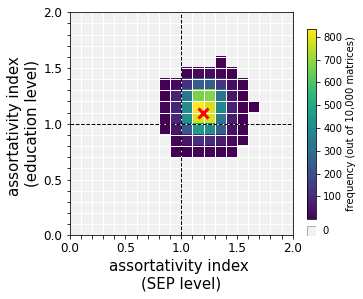

In [86]:
# Create a 2D histogram (heatmap)
x_bins = np.arange(0, 2.1, 0.1)  # Bins for x-axis
y_bins = np.arange(0, 2.1, 0.1)  # Bins for y-axis
heatmap, x_edges, y_edges = np.histogram2d(res['list_ass_sep_trace'], res['list_ass_edu_trace'], 
                                           bins=[x_bins, y_bins])

# Mask cells with a frequency of 0
masked_heatmap = np.ma.masked_where(heatmap == 0, heatmap)

# Custom colormap: set masked values to white
cmap = copy.copy(matplotlib.cm.get_cmap("viridis"))  # Base colormap
cmap.set_bad(color="lightgray", alpha = 0.3)  # Color for masked cells (frequency = 0)

# Plot the heatmap
plt.figure(figsize=(5, 5))
plt.imshow(
    masked_heatmap.T,  # Transpose to align axes correctly
    origin="lower",  # Place (0, 0) at the bottom-left
    extent=[x_bins[0], x_bins[-1], y_bins[0], y_bins[-1]],  # Set axis limits
    cmap=cmap,  # Apply the colormap
)

cbar = plt.colorbar(label="frequency (out of 10,000 matrices)", shrink = 0.7)  # Add colorbar

# Add grid and labels
plt.grid(color="white", linestyle="-", linewidth=1, alpha=1)
plt.xlabel("assortativity index \n(SEP level)", fontsize=15)
plt.ylabel("assortativity index \n(education level)", fontsize=15)
plt.xticks(np.arange(0, 2.1, 0.1), labels = [x if x in np.arange(0, 2.1, 0.5) else ' ' 
                                             for x in np.arange(0, 2.1, 0.1) ], 
           fontsize=12)
plt.yticks(np.arange(0, 2.1, 0.1), labels = [x if x in np.arange(0, 2.1, 0.5) else ' ' 
                                             for x in np.arange(0, 2.1, 0.1) ], 
           fontsize=12)

plt.scatter(np.array(res['list_ass_sep_trace'].iloc[combination]),
            np.array(res['list_ass_edu_trace'].iloc[combination]), marker="x", color = 'red', 
            s=100, linewidth=3, zorder=10)

# Add black lines at (1, 1)
plt.axvline(x=1, color="black", linestyle="--", linewidth=1)
plt.axhline(y=1, color="black", linestyle="--", linewidth=1)

# Add the small square for frequency = 0
cbar_ax = cbar.ax  # Get the colorbar axis
x0, y0, width, height = cbar_ax.get_position().bounds  # Get the bounds of the colorbar
square_height = height * 0.05  # Height for the small square

# Add the square with a black edge and white facecolor
small_square_ax = plt.gcf().add_axes([x0, y0 - square_height-0.02, width, square_height], frame_on=False)
plt.gca().add_patch(plt.Rectangle((0, 0), 1, 1, facecolor="lightgray", alpha = 0.3, edgecolor="black", transform=plt.gca().transAxes))
plt.gca().text(2, 0.5, "0", ha="center", va="center", transform=plt.gca().transAxes, fontsize=10)
#small_square_ax.spines['bottom'].set_visible(False)  # Hide axes spines
small_square_ax.set_xticks([])  # Hide x-axis ticks
small_square_ax.set_yticks([])  # Hide y-axis ticks
small_square_ax.set_xticklabels([])  # Hide x-axis labels
small_square_ax.set_yticklabels([])  # Hide y-axis labels

# Save and display
#plt.savefig("./heatmap_assortativity.png", dpi=200, bbox_inches="tight")
plt.savefig("./../output/figures/assortativity_plane_frequency.png", dpi=200, bbox_inches="tight")

plt.show()

In [87]:
100*len(res[(res['list_ass_sep_trace']<=1.0) & (res['list_ass_edu_trace']<=1.0)])/len(res)

0.69

In [88]:
100*len(res[(res['list_ass_sep_trace']<=1.0) & (res['list_ass_edu_trace']>=1.0)])/len(res)

3.02

In [89]:
100*len(res[(res['list_ass_sep_trace']>=1.0) & (res['list_ass_edu_trace']<=1.0)])/len(res)

17.89

In [90]:
100*len(res[(res['list_ass_sep_trace']>=1.0) & (res['list_ass_edu_trace']>=1.0)])/len(res)

78.4

In [91]:
100*len(res[(res['list_ass_sep_trace']>=1.0)])/len(res), 100*len(res[(res['list_ass_edu_trace']>=1.0)])/len(res)

(96.29, 81.42)

# plot R0 ratio 

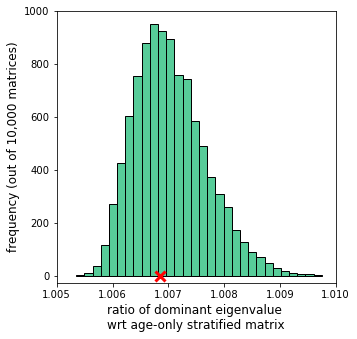

In [92]:
data = res['ratio_egv_max']
fig, ax = plt.subplots(figsize=(5, 5))

plt.hist(data, bins=30, facecolor=pal[2], edgecolor="black")
    
plt.xlabel("ratio of dominant eigenvalue \nwrt age-only stratified matrix", 
           fontsize = 12)
plt.ylabel("frequency (out of 10,000 matrices)", fontsize=12)

plt.scatter(res['ratio_egv_max'].iloc[combination], 0, zorder=10,
            marker="x", color = 'red', 
            s=100, linewidth=3)

plt.ylim([-25,1000])
plt.xticks(np.arange(1.005, 1.01, 0.001))

plt.savefig("./../output/figures/rel_increase_spectral_radius.png", 
            dpi=200, bbox_inches="tight")
plt.show()

In [93]:
data.min(), data.max()

(1.0053483664886276, 1.0097520902081134)

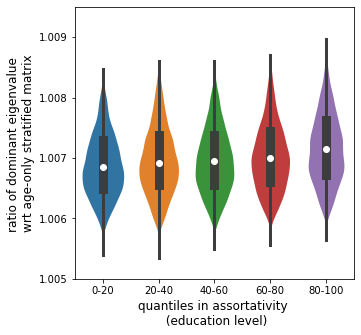

In [94]:
plt.figure(figsize=(5,5))

df = matrix_features.copy()

violin = sns.violinplot(data=df, x='list_ass_edu_trace_quant', y='ratio_egv_max', 
               order=['0-20', '20-40', '40-60', '60-80', '80-100'], 
               edgecolor="white", inner='box', cut=0, bw=0.2, linewidth=3)

for artist in violin.collections:
    artist.set_edgecolor("white")
    
#plt.yticks(np.arange(0.4, 0.9, 0.05), fontsize=12)
plt.ylim([1.005, 1.0095])
plt.ylabel("ratio of dominant eigenvalue \nwrt age-only stratified matrix", fontsize=12)
plt.xlabel('quantiles in assortativity \n (education level)', fontsize=12)
plt.xticks(ticks=np.arange(5), labels=['0-20', '20-40', '40-60', '60-80', '80-100'])

plt.savefig("./../output/figures/spectral_radius_assortativityEDU_correlation.png", bbox_inches="tight", 
            dpi=200)
plt.show()

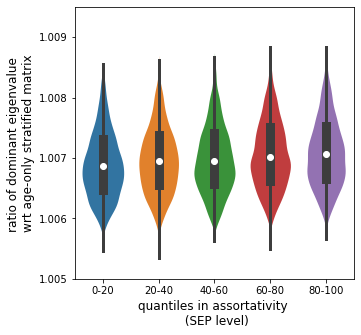

In [95]:
plt.figure(figsize=(5,5))

df = matrix_features.copy()

violin = sns.violinplot(data=df, x='list_ass_sep_trace_quant', y='ratio_egv_max', 
               order=['0-20', '20-40', '40-60', '60-80', '80-100'], 
               edgecolor="white", inner='box', cut=0, bw=0.2, linewidth=3)

for artist in violin.collections:
    artist.set_edgecolor("white")

plt.ylim([1.005, 1.0095])
plt.ylabel("ratio of dominant eigenvalue \nwrt age-only stratified matrix", fontsize=12)
plt.xlabel('quantiles in assortativity \n (SEP level)', fontsize=12)
plt.xticks(ticks=np.arange(5), labels=['0-20', '20-40', '40-60', '60-80', '80-100'])

plt.savefig("./../output/figures/spectral_radius_assortativitySEP_correlation.png", bbox_inches="tight", 
            dpi=200)
plt.show()

# R0 ratio with age and one social dimension only

In [96]:
matrix_rec = pd.read_csv("./../output/matrices/matrix_rec.csv", index_col = 0)
matrix_rec 

,0-14,15-24,25-64,65+
age_part_4cat,,,,
0-14,5.542891,0.514395,3.383834,0.443207
15-24,0.761460,3.000000,3.669290,0.872285
25-64,0.915785,0.670835,3.739023,0.817096
65+,0.347758,0.462358,2.368968,1.467081


In [97]:
avg_cnt = sum([matrix_rec.loc[g].sum()*pop_age[g] for g in matrix_rec.index])/sum(pop_age.values())
avg_cnt

6.6383909079288035

In [98]:
def compute_R0(matrix):
    
    if matrix.shape[0]>8:
        matrix = matrix.drop(['0-14, low SEP, high edu', '0-14, high SEP, high edu']).copy()
        matrix = matrix.drop(columns=['0-14, low SEP, high edu', '0-14, high SEP, high edu']).copy()
    
    return LA.eigvals(matrix).max()

In [99]:
def compute_M_sep_age(matrix_expanded):
    
    a = []
    tag = []
    for age_i in ['0-14', '15-24', '25-64', '65+']:
        for sep_i in ['low SEP', 'high SEP']:
            tag.append("{}, {}".format(age_i, sep_i))
            for age_j in ['0-14', '15-24', '25-64', '65+']:
                for sep_j in ['low SEP', 'high SEP']:
                    idx = [h for h in matrix_expanded.index if (age_i in h and sep_i in h)]
                    col = [h for h in matrix_expanded.columns if (age_j in h and sep_j in h)]
                    sub_matrix = matrix_expanded.loc[idx][col]

                    num = sum([sub_matrix.iloc[h].sum()*dict_pop_full[idx[h]] for h in np.arange(len(sub_matrix))])
                    den = sum([dict_pop_full[idx[h]] for h in np.arange(len(sub_matrix))])
                    a.append(num/den)

    M_sep_age = pd.DataFrame(np.array(a).reshape(8,8))

    M_sep_age.index = tag
    M_sep_age.columns = tag

    return M_sep_age

def compute_M_edu_age(matrix_expanded):
    
    a = []
    tag = []
    for age_i in ['0-14', '15-24', '25-64', '65+']:
        for sep_i in ['low edu', 'high edu']:
            tag.append("{}, {}".format(age_i, sep_i))
            for age_j in ['0-14', '15-24', '25-64', '65+']:
                for sep_j in ['low edu', 'high edu']:
                    idx = [h for h in matrix_expanded.index if (age_i in h and sep_i in h)]
                    col = [h for h in matrix_expanded.columns if (age_j in h and sep_j in h)]
                    sub_matrix = matrix_expanded.loc[idx][col]

                    num = sum([sub_matrix.iloc[h].sum()*dict_pop_full[idx[h]] for h in np.arange(len(sub_matrix))])
                    den = sum([dict_pop_full[idx[h]] for h in np.arange(len(sub_matrix))])
                    if den != 0.:
                        a.append(num/den)
                    else:
                        a.append(np.nan)

    M_edu_age = pd.DataFrame(np.array(a).reshape(8,8))

    M_edu_age.index = tag
    M_edu_age.columns = tag
    
    M_edu_age = M_edu_age.drop(['0-14, high edu']).copy()
    M_edu_age = M_edu_age.drop(columns=['0-14, high edu']).copy()

    return M_edu_age

def compute_M_edu_sep(matrix_expanded):
    
    a = []
    tag = []
    for age_i in ['low SEP', 'high SEP']:
        for sep_i in ['low edu', 'high edu']:
            tag.append("{}, {}".format(age_i, sep_i))
            for age_j in ['low SEP', 'high SEP']:
                for sep_j in ['low edu', 'high edu']:
                    idx = [h for h in matrix_expanded.index if (age_i in h and sep_i in h)]
                    col = [h for h in matrix_expanded.columns if (age_j in h and sep_j in h)]
                    sub_matrix = matrix_expanded.loc[idx][col]

                    num = sum([sub_matrix.iloc[h].sum()*dict_pop_full[idx[h]] for h in np.arange(len(sub_matrix))])
                    den = sum([dict_pop_full[idx[h]] for h in np.arange(len(sub_matrix))])
                    if den != 0.:
                        a.append(num/den)
                    else:
                        a.append(np.nan)

    M_edu_sep = pd.DataFrame(np.array(a).reshape(4,4))

    M_edu_sep.index = tag
    M_edu_sep.columns = tag
    
    return M_edu_sep

In [100]:
compute_M_sep_age(matrix_expanded)

,"0-14, low SEP","0-14, high SEP","15-24, low SEP","15-24, high SEP","25-64, low SEP","25-64, high SEP","65+, low SEP","65+, high SEP"
"0-14, low SEP",5.395392,0.169735,0.345832,0.172481,1.252890,2.130325,0.250522,0.234567
"0-14, high SEP",0.077053,5.455743,0.147696,0.364920,0.938270,2.445846,0.052398,0.371797
"15-24, low SEP",0.493479,0.464250,0.610674,2.926097,0.604031,3.558280,0.316656,0.820711
"15-24, high SEP",0.117909,0.549524,1.401822,1.341024,1.243824,2.189272,0.183120,0.562171
"25-64, low SEP",0.350861,0.578804,0.118544,0.509535,1.410779,2.388003,0.424460,0.501346
"25-64, high SEP",0.257796,0.651991,0.301765,0.387546,1.031914,2.681286,0.189409,0.580710
"65+, low SEP",0.192286,0.088592,0.170328,0.205602,1.163362,1.201352,1.174002,0.408644
"65+, high SEP",0.084406,0.294708,0.206963,0.295915,0.644199,1.726763,0.191580,1.221321


In [101]:
compute_M_edu_age(matrix_expanded)

,"0-14, low edu","15-24, low edu","15-24, high edu","25-64, low edu","25-64, high edu","65+, low edu","65+, high edu"
"0-14, low edu",5.542891,0.480532,0.033862,1.725990,1.657844,0.199073,0.244134
"15-24, low edu",0.778026,2.824518,0.179612,1.983748,1.570853,0.509444,0.279745
"15-24, high edu",0.584774,1.915727,1.040222,2.330008,2.562552,0.815683,0.942902
"25-64, low edu",0.856804,0.608216,0.066978,2.067320,1.609289,0.543973,0.300935
"25-64, high edu",0.986486,0.577312,0.088298,1.929026,1.884813,0.565588,0.218169
"65+, low edu",0.214811,0.339523,0.050968,1.182441,1.025647,1.254155,0.146466
"65+, high edu",0.702072,0.496870,0.157018,1.743340,1.054385,0.390342,1.253857


list_eigv_ratio_keep_sep = []
list_eigv_ratio_keep_edu = []

for c in range(10000):
    matrix_expanded = generate_matrix(c)
    
    M_sep_age = compute_M_sep_age(matrix_expanded)
    
    M_edu_age = compute_M_edu_age(matrix_expanded)
    
    ratio_sep = compute_R0(M_sep_age)/compute_R0(matrix_rec)
    ratio_edu = compute_R0(M_edu_age)/compute_R0(matrix_rec)    
    
    list_eigv_ratio_keep_sep.append(ratio_sep)
    list_eigv_ratio_keep_edu.append(ratio_edu)    

matrix_features['list_eigv_ratio_keep_sep'] = list_eigv_ratio_keep_sep
matrix_features['list_eigv_ratio_keep_edu'] = list_eigv_ratio_keep_edu

#matrix_features.to_csv("./../output/matrices/10000_matrices_characteristics.csv", index=False)

In [102]:
matrix_features = pd.read_csv("./../output/matrices/10000_matrices_characteristics.csv")

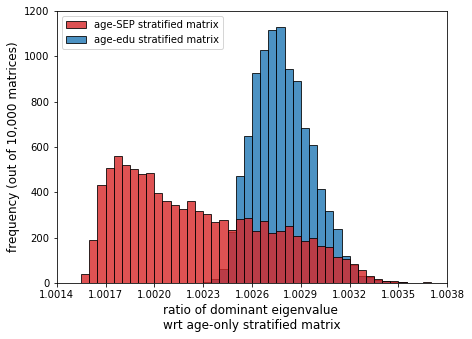

In [103]:
fig, ax = plt.subplots(figsize=(7, 5))

#data = matrix_features['ratio_egv_max']
#plt.hist(data, bins=30, facecolor=pal[2], edgecolor="black")


data = matrix_features['list_eigv_ratio_keep_sep']
#data = list_eigv_ratio_keep_sep
plt.hist(data, bins=np.arange(1.0012, 1.0039, 0.00005), alpha= 0.8, 
         facecolor='tab:red', edgecolor="black", label="age-SEP stratified matrix", zorder = 10)

data = matrix_features['list_eigv_ratio_keep_edu']
#data = list_eigv_ratio_keep_edu
plt.hist(data, bins=np.arange(1.0012, 1.0039, 0.00005), alpha= 0.8, 
         facecolor='tab:blue', edgecolor="black", label="age-edu stratified matrix")
    
plt.xlabel("ratio of dominant eigenvalue \nwrt age-only stratified matrix", 
           fontsize = 12)
plt.ylabel("frequency (out of 10,000 matrices)", fontsize=12)

plt.legend()

#plt.scatter(res['ratio_egv_max'].iloc[combination], 0, zorder=10,
#            marker="x", color = 'red', 
#            s=100, linewidth=3)

plt.ylim([0,1200])
plt.xticks(np.arange(1.0014, 1.0040, 0.0003))
plt.xlim([1.0014, 1.0038])

plt.savefig("./../output/figures/rel_increase_spectral_radius_one_social_dimension.png", 
            dpi=200, bbox_inches="tight")
plt.show()

In [104]:
matrix_features['list_eigv_ratio_keep_sep'].min(), matrix_features['list_eigv_ratio_keep_sep'].median(), matrix_features['list_eigv_ratio_keep_sep'].max()

(1.0015502625284027, 1.0021770504305696, 1.0036564981199698)

In [105]:
matrix_features['list_eigv_ratio_keep_edu'].min(), matrix_features['list_eigv_ratio_keep_edu'].median(), matrix_features['list_eigv_ratio_keep_edu'].max()

(1.0022720560144596, 1.0027718853152296, 1.0036086622460465)

## R0 ratio with only one dimension (age or SEP or SES) wrt homogeneous mixing (no stratification)

In [106]:
compute_R0(matrix_rec)/avg_cnt

1.1117482140867392

In [107]:
list_eigv_ratio_only_sep = []
list_eigv_ratio_only_edu = []

for c in range(10000):
    
    matrix_expanded = generate_matrix(c)
    
    M_sep = compute_M_sep(matrix_expanded)
    
    M_edu = compute_M_edu(matrix_expanded)
    
    ratio_sep = compute_R0(M_sep)/avg_cnt
    ratio_edu = compute_R0(M_edu)/avg_cnt  
    
    list_eigv_ratio_only_sep.append(ratio_sep)
    list_eigv_ratio_only_edu.append(ratio_edu)    

In [108]:
list_eigv_ratio_edu_sep = []

for c in range(10000):
    
    matrix_expanded = generate_matrix(c)
    
    M_edu_sep = compute_M_edu_sep(matrix_expanded)
    
    ratio = compute_R0(M_edu_sep)/avg_cnt 
    
    list_eigv_ratio_edu_sep.append(ratio)   

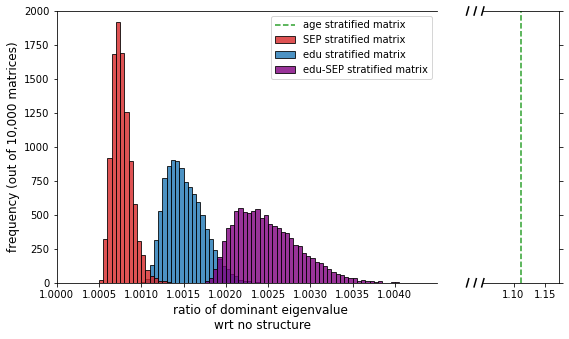

In [110]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, 
                               gridspec_kw={'width_ratios': [5, 1]}, 
                               figsize=(9, 5))

data = list_eigv_ratio_only_sep
ax1.hist(data, bins=np.arange(1.0, 1.0039, 0.00005), alpha= 0.8, 
         facecolor='tab:red', edgecolor="black", label="SEP stratified matrix", zorder = 10)
data = list_eigv_ratio_only_edu
ax1.hist(data, bins=np.arange(1.0, 1.0039, 0.00005), alpha= 0.8, 
         facecolor='tab:blue', edgecolor="black", label="edu stratified matrix")

data = list_eigv_ratio_edu_sep
ax1.hist(data, bins=np.arange(1.0, 1.01, 0.00005), alpha= 0.8, 
         facecolor='purple', edgecolor="black", label="edu-SEP stratified matrix")


ax1.set_xticks(np.arange(1.0, 1.0040, 0.0005))
ax1.set_xlim([1.0, 1.0045])
ax1.set_yticks(np.arange(0,2100, 250))
ax1.set_ylim([0,2000])

ax1.axvline(compute_R0(matrix_rec)/avg_cnt, linestyle="dashed", color='tab:green', 
            label="age stratified matrix")

ax2.axvline(compute_R0(matrix_rec)/avg_cnt, linestyle="dashed", color='tab:green')

ax2.set_ylim([0,2000])
   
ax1.set_xlabel("        ratio of dominant eigenvalue \n        wrt no structure", 
           fontsize = 12)
ax1.set_ylabel("frequency (out of 10,000 matrices)", fontsize=12)

ax1.legend()

# Remove x-axis ticks and labels in the middle

ax1.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax1.yaxis.tick_left()
ax2.yaxis.tick_right()
#ax2.yaxis.set_ticks([])

# Add diagonal lines to indicate the break (ensuring parallel alignment)
d = 0.015  # Size of diagonal lines
shift = 0.1
kwargs = dict(transform=ax1.transAxes, color='black', clip_on=False, linewidth=1.5)

#ax1.plot([1 - d, 1 + d], [-d, +d], **kwargs)  # Bottom diagonal
#ax1.plot([1 - d, 1 + d], [1 - d, 1 + d], **kwargs)  # Top diagonal

kwargs.update(transform=ax2.transAxes)  
ax2.plot([-d, +d], [-d, +d], **kwargs)  # Bottom diagonal
ax2.plot([-d, +d], [1 - d, 1 + d], **kwargs)  # Top diagonal
ax2.plot([-d-shift, +d-shift], [-d, +d], **kwargs)  # Bottom diagonal
ax2.plot([-d-shift, +d-shift], [1 - d, 1 + d], **kwargs)  # Top diagonal
ax2.plot([-d-2*shift, +d-2*shift], [-d, +d], **kwargs)  # Bottom diagonal
ax2.plot([-d-2*shift, +d-2*shift], [1 - d, 1 + d], **kwargs)  # Top diagonal

plt.savefig("./../output/figures/rel_increase_spectral_radius_wrt_no_stratification_broken_axis.png", 
            dpi=200, bbox_inches="tight")
plt.show()